Modify the KNN scratch code in our lecture such that:
- If the majority class of the first place is equal to the second place, then ask the algorithm to pick the next nearest neighbors as the decider
- Modify the code so it outputs the probability of the decision, where the probability is simply the class probability based on all the nearest neighbors
- Write a function which allows the program to receive a range of k, and output the cross validation score.  Last, it shall inform us which k is the best to use from a predefined range
- Put everything into a class <code>KNN(k=3)</code>.  It should have at least one method, <code>predict(X_train, X_test, y_train)</code>

In [1]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

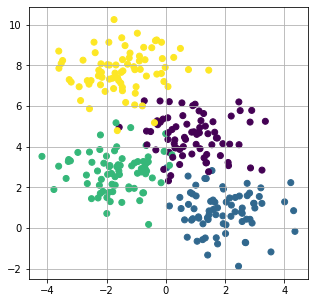

In [2]:
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

xfit = np.linspace(-1, 3.5)

figure = plt.figure(figsize=(5, 5))
ax = plt.axes()  #get the instance of axes from plt

ax.grid()
ax.scatter(X[:, 0], X[:, 1], c=y)

In [3]:
#standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

#do train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [4]:
class KNN:
    def __init__(self, k=3):
        self.k = k

    def find_distance(self, X_train, X_test):
        dist = X_test[:, np.newaxis, :] - X_train[np.newaxis, :, :]
        dist = dist ** 2
        dist = dist.sum(axis=2)
        dist = np.sqrt(dist)
        return dist

    def find_neighbors(self, X_train, X_test):
        dist = self.find_distance(X_train, X_test)
        neighbors_ix = np.argsort(dist)[:,:]
        return neighbors_ix

    def get_first_second_common(self, y, k, n_class):
        y_bincount = np.bincount(y[0:k], minlength=n_class)
        y_sort_idx = np.argsort(y_bincount)
        first_common = y_sort_idx[-1]
        second_common = y_sort_idx[-2]
        return first_common, second_common, y_bincount
    
    def find_prob(self, y_bincount):
        prob = (y_bincount / y_bincount.sum()).max()
        return prob

    def get_most_common(self, y, n_class, k):
        most_commons = []
        probs = []
        for i in range(y.shape[0]):
            first_common, second_common, y_bincount = self.get_first_second_common(y[i], k, n_class)
            
            if y_bincount[first_common] == y_bincount[second_common]:
                first_common, second_common, y_bincount = self.get_first_second_common(y[i], k+1, n_class)
                most_commons.append(first_common)
            else:
                most_commons.append(first_common)
            prob = self.find_prob(y_bincount)
            probs.append(prob)
        return np.array(most_commons), np.array(probs)

    def predict(self, X_train, X_test, y_train):
        neighbors_idx = self.find_neighbors(X_train, X_test)
        n_class = np.unique(y_train).shape[0]
        predicted, probs = self.get_most_common(y_train[neighbors_idx], n_class, self.k)
        return predicted, probs

    def cross_validate_k(self, X_train, y_train, k_range, cv):
        foldsize = int(X_train.shape[0]/cv)

        for k_value in k_range:
            self.k = k_value
            cv_score = np.zeros(cv)
            cv_prob = np.zeros(cv)

            for f_idx, f_part in enumerate(range(0, X_train.shape[0], foldsize)):
                X_test_ = X_train[f_part:f_part+foldsize]
                y_test_ = y_train[f_part:f_part+foldsize]
                X_train_ = np.concatenate((X_train[:f_part], X_train[f_part+foldsize:]))
                y_train_ = np.concatenate((y_train[:f_part], y_train[f_part+foldsize:]))
                predicts, probs = self.predict(X_train_, X_test_, y_train_)
                accuracy = np.count_nonzero(np.array([y_test_ == predicts]))/y_test_.shape[0]
                cv_score[f_idx] = accuracy
                cv_prob[f_idx] = probs.mean()

            print(f'Case k = {k_value}: score = {cv_score.mean()} average prob = {cv_prob.mean()}')

In [5]:
model = KNN(k=4)
predict,_ = model.predict(X_train, X_test, y_train)
print('============== The accuracy of model ===============')
print(np.count_nonzero(np.array([y_test == predict]))/y_test.shape[0])
print('============== The classification report ===============')
print(classification_report(y_test, predict))


============== The accuracy of model ===============
0.9666666666666667
============== The classification report ===============
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       1.00      0.96      0.98        25
           2       0.95      0.95      0.95        20
           3       1.00      1.00      1.00        25

    accuracy                           0.97        90
   macro avg       0.96      0.96      0.96        90
weighted avg       0.97      0.97      0.97        90



In [6]:
model = KNN()
k_range = np.arange(2, 20)
model.cross_validate_k(X_train, y_train, k_range, cv=10)

Case k = 2: score = 0.9095238095238095 average prob = 0.9571428571428571
Case k = 3: score = 0.9142857142857144 average prob = 0.9476190476190476
Case k = 4: score = 0.9238095238095239 average prob = 0.9400000000000001
Case k = 5: score = 0.9333333333333333 average prob = 0.9333333333333333
Case k = 6: score = 0.9380952380952381 average prob = 0.9246031746031745
Case k = 7: score = 0.9428571428571428 average prob = 0.9238095238095237
Case k = 8: score = 0.9333333333333333 average prob = 0.9199735449735449
Case k = 9: score = 0.9285714285714286 average prob = 0.9185185185185185
Case k = 10: score = 0.9285714285714286 average prob = 0.9159307359307359
Case k = 11: score = 0.9238095238095239 average prob = 0.91497113997114
Case k = 12: score = 0.9190476190476191 average prob = 0.9124542124542124
Case k = 13: score = 0.9142857142857144 average prob = 0.9097592883307171
Case k = 14: score = 0.9095238095238096 average prob = 0.9045578231292517
Case k = 15: score = 0.9142857142857144 average 